## Treatment

In [2]:
import pandas as pd
data_ = pd.read_excel('data/ml.xlsx', sheet_name=None)

key_mapper = {
    'FEMA - Major Disaster - Fire': 'fire',
    'FEMA - Major Disaster - Earthqu': 'earthquake',
    'FEMA - Major Disaster - Hurrica': 'hurricane',
    'FEMA - Major Disaster - Tornado': 'tornado',
    'FEMA - Major Disaster - Flood': 'flood',
    }
data_ = {key_mapper.get(old_key, old_key): value for old_key, value in data_.items()}

Will update the df when more Marie-Laure will fullfill the excel sheet

In [3]:
df_ = data_['fire'].loc[:,['State', 'Declaration Date', 'Incident Type']]

from countries_code import code
df_['State'] = df_['State'].map(code)
df_.head()

,State,Declaration Date,Incident Type
0,CA,2021-09-12,Fire
1,CA,2021-08-24,Fire
2,WA,2021-02-04,Fire
3,CO,2021-01-15,Fire
4,MT,2021-09-30,Fire


In [4]:
import plotly.express as px

fig = px.choropleth(
    df_.groupby(["State"]).count().reset_index(),
    locations="State",
    color="Declaration Date",
    color_continuous_scale="spectral_r",
    hover_name="State",
    locationmode="USA-states",
    scope="usa",
    labels={"Declaration Date": "Number of incidents"},
)
fig.add_scattergeo(
    locations=df_["State"], locationmode="USA-states", text=df_["State"], mode="text"
)

fig.show()

## Outcomes


Files need to be merged

In [5]:
files_ = [
    f"data/CDC/{data_file}"
    for data_file in os.listdir("data/CDC")
    if "txt" in data_file
]

columns = ["State", "Month Code", "UCD - ICD Chapter", "Deaths"]

df_outcomes_ = pd.concat(
    objs=[
        pd.read_csv(file, delimiter="\t", parse_dates=["Month Code"])[columns].dropna()
        for file in files_
    ]
)

df_outcomes_["date"] = df_outcomes_["Month Code"]

from countries_code import code

df_outcomes_["State"] = df_outcomes_["State"].map(code)

df_outcomes_.rename(
    columns={
        "State": "state",
        "UCD - ICD Chapter": "cause",
        "Deaths": "deaths",
        "Month Code": "time",
    },
    inplace=True,
)

df_outcomes = df_outcomes_.set_index(["state", "time", "cause"])
df_outcomes.sort_index(ascending=True, inplace=True)
df_outcomes

deaths  \
state time       cause                                                   
AK    2010-01-01 Diseases of the circulatory system               78.0   
                 Diseases of the digestive system                 14.0   
                 Diseases of the nervous system                   22.0   
                 Diseases of the respiratory system               25.0   
                 Endocrine, nutritional and metabolic diseases    14.0   
...                                                                ...   
WY    2020-12-01 Diseases of the respiratory system               61.0   
                 Endocrine, nutritional and metabolic diseases    24.0   
                 External causes of morbidity and mortality       50.0   
                 Mental and behavioural disorders                 24.0   
                 Neoplasms                                        88.0   

                                                                     date  
state time       cause                                                     
AK    2010-01-01 Diseases of the circulatory system            2010-01-01  
                 Diseases of the digestive system              2010-01-01  
                 Diseases of the nervous system                2010-01-01  
                 Diseases of the respiratory system            2010-01-01  
                 Endocrine, nutritional and metabolic diseases 2010-01-01  
...                                                                   ...  
WY    2020-12-01 Diseases of the respiratory system            2020-12-01  
                 Endocrine, nutritional and metabolic diseases 2020-12-01  
                 External causes of morbidity and mortality    2020-12-01  
                 Mental and behavioural disorders              2020-12-01  
                 Neoplasms                                     2020-12-01  

[90532 rows x 2 columns]

In [6]:
import plotly
import numpy as np

date = df_outcomes_.time.min()
data_slider = []
step_ = 3

zmin, zmax = df_outcomes_.deaths.min(), df_outcomes_.deaths.max()


for add_month in range(
    1,
    int(
        (df_outcomes_.time.max() - df_outcomes_.time.min()) / np.timedelta64(1, "M") + 1
    ),
    step_,
):
    df_segmented = df_outcomes_[
        (
            df_outcomes_["time"]
            == df_outcomes_.time.min() + pd.DateOffset(months=add_month)
        )
    ]

    data_mth = dict(
        type="choropleth",
        locations=df_segmented["state"],
        z=df_segmented["deaths"],
        locationmode="USA-states",
        zmin=zmin,
        zmax=zmax/8,
        colorbar={"title": "# Deaths"},
        colorscale="Viridis",
    )

    data_slider.append(data_mth)

steps = []
for i in range(len(data_slider)):
    step = dict(
        method="restyle",
        args=["visible", [False] * len(data_slider)],
        label=str((df_outcomes_.time.min() + pd.DateOffset(months=i *step_)))[:7],
    )
    step["args"][1][i] = True
    steps.append(step)

sliders = [dict(active=0, pad={"t": 1}, steps=steps)]

layout = dict(
    title="Death By State Since 2010",
    geo=dict(scope="usa", projection={"type": "albers usa"}),
    sliders=sliders,
)

fig = dict(data=data_slider, layout=layout)
plotly.offline.iplot(fig)

In [7]:
df_outcomes_.cause.unique()

array(['Certain infectious and parasitic diseases', 'Neoplasms',
       'Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism',
       'Endocrine, nutritional and metabolic diseases',
       'Mental and behavioural disorders',
       'Diseases of the nervous system',
       'Diseases of the circulatory system',
       'Diseases of the respiratory system',
       'Diseases of the digestive system',
       'Diseases of the musculoskeletal system and connective tissue',
       'Diseases of the genitourinary system',
       'Certain conditions originating in the perinatal period',
       'Congenital malformations, deformations and chromosomal abnormalities',
       'Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified',
       'External causes of morbidity and mortality',
       'Diseases of the skin and subcutaneous tissue',
       'Pregnancy, childbirth and the puerperium',
       'Codes for special purpose

## Cofeatures

Vera Institute gives data on incarceration in the US

In [8]:
df = pd.DataFrame()

### Vera Institute DataSet

In [9]:
df_vera = pd.read_csv('data/veraInstitute/incarceration_trends.csv')

"lets reindex to sum over states"
df_vera = df_vera.set_index(['year','state', 'county_name'])
df_vera.loc[(1970, slice(None), slice(None)),:]

yfips   fips  total_pop  total_pop_15to64  \
year state county_name                                                        
1970 AL    Autauga County     197001001   1001      24661             14154   
           Baldwin County     197001003   1003      59531             35043   
           Barbour County     197001005   1005      22644             13210   
           Bibb County        197001007   1007      13824              7982   
           Blount County      197001009   1009      27042             16652   
...                                 ...    ...        ...               ...   
     WY    Sweetwater County  197056037  56037      18566             11240   
           Teton County       197056039  56039       4897              3139   
           Uinta County       197056041  56041       7083              4223   
           Washakie County    197056043  56043       7560              4602   
           Weston County      197056045  56045       6270              3690   

                              female_pop_15to64  male_pop_15to64  \
year state county_name                                             
1970 AL    Autauga County                  7293             6861   
           Baldwin County                 18072            16971   
           Barbour County                  7151             6059   
           Bibb County                     4099             3883   
           Blount County                   8538             8114   
...                                         ...              ...   
     WY    Sweetwater County               5598             5642   
           Teton County                    1569             1570   
           Uinta County                    2082             2141   
           Washakie County                 2248             2354   
           Weston County                   1868             1822   

                              aapi_pop_15to64  black_pop_15to64  \
year state county_name                                            
1970 AL    Autauga County                 NaN               NaN   
           Baldwin County                 NaN               NaN   
           Barbour County                 NaN               NaN   
           Bibb County                    NaN               NaN   
           Blount County                  NaN               NaN   
...                                       ...               ...   
     WY    Sweetwater County              NaN               NaN   
           Teton County                   NaN               NaN   
           Uinta County                   NaN               NaN   
           Washakie County                NaN               NaN   
           Weston County                  NaN               NaN   

                              latinx_pop_15to64  native_pop_15to64  ...  \
year state county_name                                              ...   
1970 AL    Autauga County                   NaN                NaN  ...   
           Baldwin County                   NaN                NaN  ...   
           Barbour County                   NaN                NaN  ...   
           Bibb County                      NaN                NaN  ...   
           Blount County                    NaN                NaN  ...   
...                                         ...                ...  ...   
     WY    Sweetwater County                NaN                NaN  ...   
           Teton County                     NaN                NaN  ...   
           Uinta County                     NaN                NaN  ...   
           Washakie County                  NaN                NaN  ...   
           Weston County                    NaN                NaN  ...   

                              native_prison_pop_rate white_prison_pop_rate  \
year state county_name                                                       
1970 AL    Autauga County                        NaN                   NaN   
           Baldwin County              

In [10]:
# use multi index capabilities to merge by state
df_vera = df_vera.groupby(level=[0, 1]).sum()
df_vera = pd.concat(
    [
        (
            df_vera.loc[:, ["total_jail_pop", "total_prison_pop"]].sum(axis=1)
            / df_vera.loc[:, "total_pop"]
        ).rename("imprisonment_rate"),
        df_vera["total_pop"],
    ],
    axis=1,
)

df_vera

imprisonment_rate  total_pop
year state                              
1970 AK              0.000392     255117
     AL              0.000874    3454557
     AR              0.000633    1932816
     AZ              0.001190    1799531
     CA              0.001380   20045806
...                       ...        ...
2018 VT              0.000000     626299
     WA              0.001694    7535591
     WI              0.002294    5813568
     WV              0.002932    1805832
     WY              0.002666     577737

[2499 rows x 2 columns]

## Census Datasets

Data coming from https://www.census.gov/acs/www/data/data-tables-and-tools/data-profiles/2020/

In [11]:
def yearly_to_monthly(df: pd.DataFrame) -> pd.DataFrame:
    """The dataframe needs to cointain the state and year columns."""
    df_ = pd.concat(
        {month: df for month in [1, 12]}, names=["month"]
    ).reorder_levels(["year", "month", "state"]).reset_index().set_index("state")

    df_["date"] = (
        df_["year"].astype(str) + "-" + df_["month"].astype(str)
    ).astype("datetime64[ns]")

    return df_.reset_index().set_index(['state', 'date']).drop(columns=["year", "month"])

In [12]:
from countries_code import code


def census_loader(path: str = "data/census/economics", pattern: str = "ACSDP1Y"):
    df_ = {
        year: processed_dataframe
        for year, processed_dataframe in zip(
            map(
                # extract the year from the name of the file
                lambda l: l[
                    l.index(pattern)
                    + len(pattern) : l.index(pattern)
                    + len(pattern)
                    + 4
                ],
                files_,
            ),
            map(
                # process the dataframe: map state names, remove uncertaincy and transpose
                lambda df: df.rename(columns={"Unnamed: 0": ""})
                # .set_index("")
                .iloc[
                    1:,
                    ~df.columns.str.contains("^Unnamed")
                    # 1 slice because unamed 0 became index already
                ]
                .replace("(X)", np.nan)
                .rename(columns=code)
                .transpose()
                .reset_index()
                .rename(columns={"index": "state"}),
                [pd.read_csv(file, header=[0]) for file in files_],
            ),
        )
    }

    for year, df in df_.items():
        df["year"] = year
        df.set_index(["state", "year"], inplace=True)
        # df.columns = df.columns.str.strip()
        # df.set_index(["state", "year"], inplace=True)

    return pd.concat(df_.values())

### Economics

In [13]:
df_economics = census_loader(path="data/census/economics")
df_economics = df_economics.rename(columns={i: "e{}".format(i) for i in range(len(df_economics.columns))})
df_economics

ParserError: Error tokenizing data. C error: Expected 2 fields in line 5, saw 3


dtw dynamic time wrapping
stabilized iptw, tronquer, stabiliser ou reassigner

### Demographic

In [14]:
df_demographic = census_loader(path="data/census/demographic")
df_demographic = df_demographic.rename(columns={i: "d{}".format(i) for i in range(len(df_demographic.columns))})
df_demographic


ParserError: Error tokenizing data. C error: Expected 2 fields in line 5, saw 3


### Housing

In [372]:
df_housing = census_loader(path="data/census/housing")
df_housing = df_housing.rename(columns={i: "h{}".format(i) for i in range(len(df_housing.columns))})
df_housing

,,h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,...,h136,h137,h138,h139,h140,h141,h142,h143,h144,145
state,year,,,,,,,,,,,,,,,,,,,,,
AL,2011,NaN,"3,808,975","2,255,995","2,240,441","1,981,095","259,346","15,554","1,552,980","2,240,441",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AK,2011,NaN,"554,678","394,406","377,710","344,343","33,367","16,696","160,272","377,710",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AZ,2011,NaN,"5,044,259","3,040,762","3,025,208","2,687,991","337,217","15,554","2,003,497","3,025,208",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AR,2011,NaN,"2,301,244","1,368,632","1,363,235","1,235,755","127,480","5,397","932,612","1,363,235",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CA,2011,NaN,"29,530,797","18,869,522","18,737,749","16,426,694","2,311,055","131,773","10,661,275","18,737,749",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WA,2015,NaN,"5,741,873","3,658,933","3,613,427","3,397,974","215,453","45,506","2,082,940","3,613,427",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WV,2015,NaN,"1,508,224","797,526","796,708","738,438","58,270",818,"710,698","796,708",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WI,2015,NaN,"4,627,790","3,094,071","3,091,421","2,959,655","131,766","2,650","1,533,719","3,091,421",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Social

In [376]:
df_social = census_loader(path="data/census/social")
df_social = df_social.rename(columns={i: "s{}".format(i) for i in range(len(df_social.columns))})
df_social

,,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,...,s136,s137,s138,s139,s140,s141,s142,s143,s144,145
state,year,,,,,,,,,,,,,,,,,,,,,
AL,2011,NaN,"3,808,975","2,255,995","2,240,441","1,981,095","259,346","15,554","1,552,980","2,240,441",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AK,2011,NaN,"554,678","394,406","377,710","344,343","33,367","16,696","160,272","377,710",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AZ,2011,NaN,"5,044,259","3,040,762","3,025,208","2,687,991","337,217","15,554","2,003,497","3,025,208",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AR,2011,NaN,"2,301,244","1,368,632","1,363,235","1,235,755","127,480","5,397","932,612","1,363,235",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CA,2011,NaN,"29,530,797","18,869,522","18,737,749","16,426,694","2,311,055","131,773","10,661,275","18,737,749",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WA,2015,NaN,"5,741,873","3,658,933","3,613,427","3,397,974","215,453","45,506","2,082,940","3,613,427",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WV,2015,NaN,"1,508,224","797,526","796,708","738,438","58,270",818,"710,698","796,708",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WI,2015,NaN,"4,627,790","3,094,071","3,091,421","2,959,655","131,766","2,650","1,533,719","3,091,421",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Regression Discontuinty

In [15]:
observed_outcome = [
    "Diseases of the circulatory system",
    "Diseases of the respiratory system",
]

short_outcome = ["circulatory system","respiratory system"]


df_observed = pd.concat(
    [
        (
            df_outcomes.loc[(slice(None), slice(None), outcome), :]
            .reset_index()
            .set_index(["state", "time"])
            .rename(columns={"deaths": "{}deaths".format(short_outcome[:3])})
            .drop("cause", axis=1)
        )
        for outcome, short_outcome in zip(observed_outcome,short_outcome)
    ],
    axis=1,
)
df_observed = df_observed.loc[:, ~df_observed.columns.duplicated()]

df_observed

cirdeaths       date  resdeaths
state time                                       
AK    2010-01-01       78.0 2010-01-01       25.0
      2010-02-01       74.0 2010-02-01       23.0
      2010-03-01       64.0 2010-03-01       23.0
      2010-04-01       75.0 2010-04-01       41.0
      2010-05-01       62.0 2010-05-01       29.0
...                     ...        ...        ...
WY    2020-08-01      118.0 2020-08-01       47.0
      2020-09-01      145.0 2020-09-01       43.0
      2020-10-01      144.0 2020-10-01       56.0
      2020-11-01      122.0 2020-11-01       41.0
      2020-12-01      143.0 2020-12-01       61.0

[6732 rows x 3 columns]

In [16]:
df_ = df_observed.loc[
    ("CA", slice(None)),:
]

disaster_date= "2015-9-22"
df_.loc[:,"date"] = ((df_.loc[:,"date"] - pd.to_datetime(disaster_date))/ np.timedelta64(1, 'D')).astype(int)
df_

/var/folders/m8/sb3p17zj07s4h28sd6njtsbw0000gn/T/ipykernel_4846/2531041686.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



cirdeaths  date  resdeaths
state time                                  
CA    2010-01-01     7313.0 -2090     2268.0
      2010-02-01     6610.0 -2059     2045.0
      2010-03-01     7177.0 -2031     2407.0
      2010-04-01     6692.0 -2000     2000.0
      2010-05-01     6683.0 -1970     1896.0
...                     ...   ...        ...
      2020-08-01     7606.0  1775     1643.0
      2020-09-01     7156.0  1806     1537.0
      2020-10-01     7259.0  1836     1563.0
      2020-11-01     7819.0  1867     1703.0
      2020-12-01     9614.0  1897     2113.0

[132 rows x 3 columns]

<AxesSubplot:title={'center':'respiratory disease in California'}, xlabel='date', ylabel='resdeaths'>

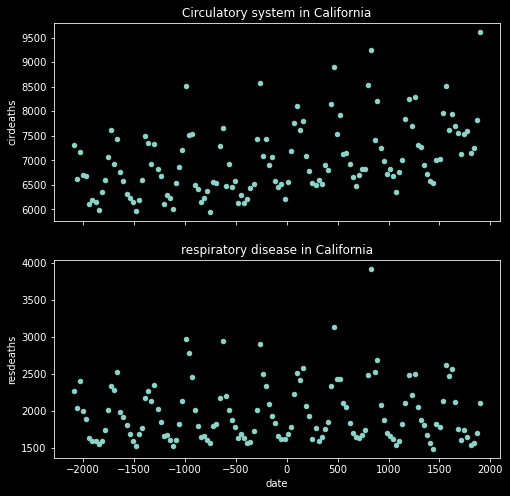

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
ax = plt.subplot(2, 1, 1)
df_.plot.scatter(
    y="cirdeaths",
    x="date",
    title="Circulatory system in California",
    ax=ax,
)
ax = plt.subplot(2, 1, 2, sharex=ax)
df_.plot.scatter(
    y="resdeaths",
    x="date",
    title="respiratory disease in California",
    ax=ax,
)

In [18]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

rdd_df = df_.assign(threshold=(df_["date"] > 0).astype(int))

model = smf.wls("cirdeaths~date*threshold", rdd_df).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6778.3668,154.299,43.930,0.000,6473.059,7083.675
date,0.0600,0.127,0.473,0.637,-0.191,0.311
threshold,315.3153,222.333,1.418,0.159,-124.610,755.240
date:threshold,0.2040,0.193,1.058,0.292,-0.177,0.585


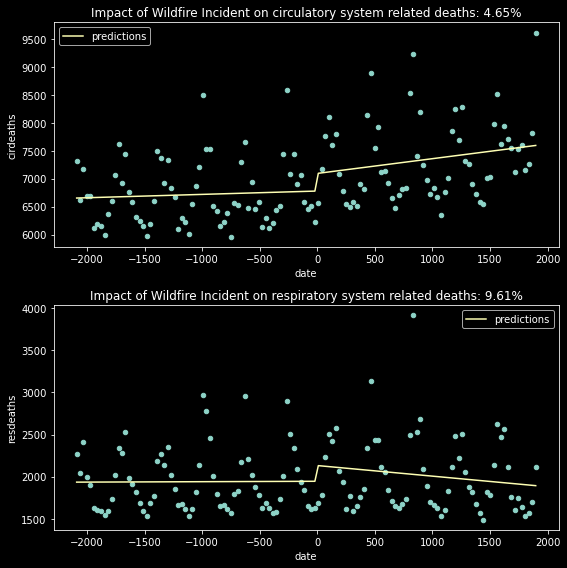

In [19]:
plt.figure(figsize=(8, 8))
for p, short_o in enumerate(short_outcome, 1):
    ax = plt.subplot(2, 1, p)
    df_.plot.scatter(x="date", y="{}deaths".format(short_o[:3]), ax=ax)
    m = smf.wls(f"{short_o[:3]}deaths~date*threshold", rdd_df).fit()
    ate_pct = 100 * (
        (m.params["threshold"] + m.params["Intercept"]) / m.params["Intercept"] - 1
    )
    df_.assign(predictions=m.fittedvalues).plot(
        x="date", y="predictions", ax=ax, color="C1"
    )
    plt.title(
        f"Impact of Wildfire Incident on {short_o} related deaths: {np.round(ate_pct, 2)}%"
    )

plt.tight_layout()

Check the periodicity with FFT

2022-05-02 13:37:43.662436: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


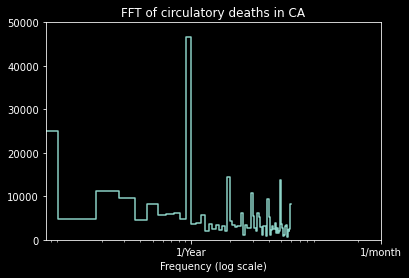

In [20]:
import tensorflow as tf

fft = tf.signal.rfft(df_["cirdeaths"])
f_per_dataset = np.arange(0, len(fft))

n_samples_m = len(df_["cirdeaths"])
months_per_year = 12
years_per_dataset = n_samples_m / (months_per_year)

f_per_year = f_per_dataset / years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale("log")
plt.ylim(0, 50000)
# plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 30], labels=["1/Year", "1/month"])
plt.title("FFT of circulatory deaths in CA")
_ = plt.xlabel("Frequency (log scale)")

Add kernel
$$K(R, c, h) = \mathcal{1}\{|R-c| \leq h\} * \bigg(1-\frac{|R-c|}{h}\bigg)

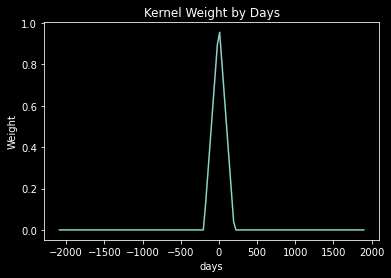

In [21]:
def kernel(R, c, h):
    indicator = (np.abs(R-c) <= h).astype(float)
    return indicator * (1 - np.abs(R-c)/h)

plt.plot(df_["date"], kernel(df_["date"], c=0, h=200))
plt.xlabel("days")
plt.ylabel("Weight")
plt.title("Kernel Weight by Days");

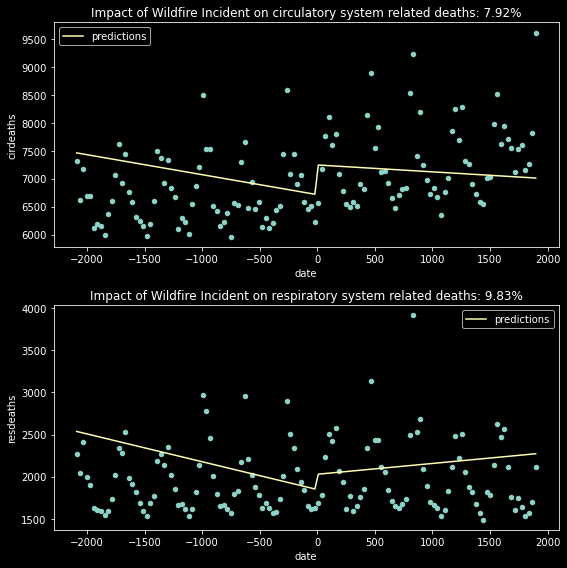

In [22]:
plt.figure(figsize=(8, 8))
for p, short_o in enumerate(short_outcome, 1):
    ax = plt.subplot(2, 1, p)
    df_.plot.scatter(x="date", y="{}deaths".format(short_o[:3]), ax=ax)
    m = smf.wls(
        f"{short_o[:3]}deaths~date*threshold",
        rdd_df,
        weights=kernel(df_["date"], c=0, h=600),
    ).fit()
    ate_pct = 100 * (
        (m.params["threshold"] + m.params["Intercept"]) / m.params["Intercept"] - 1
    )
    df_.assign(predictions=m.fittedvalues).plot(
        x="date", y="predictions", ax=ax, color="C1"
    )
    plt.title(
        f"Impact of Wildfire Incident on {short_o} related deaths: {np.round(ate_pct, 2)}%"
    )

plt.tight_layout()

In [23]:
m.summary()

/Users/arnaudpetit/mambaforge/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:776: RuntimeWarning:

divide by zero encountered in log



<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:              resdeaths   R-squared:                       0.043
Model:                            WLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     1.911
Date:                Mon, 02 May 2022   Prob (F-statistic):              0.131
Time:                        13:37:50   Log-Likelihood:                   -inf
No. Observations:                 132   AIC:                               inf
Df Residuals:                     128   BIC:                               inf
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1846.8541     82.410     22.410      0.000    1683.791    2009.917
date              -0.3303      0.333     -0.991      0.323      -0.990       0.329
threshold        181.6352    113.072      1.606      0.111     -42.098     405.368
date:threshold     0.4587      0.461      0.995      0.322      -0.454       1.371
==============================================================================
Omnibus:                       64.848   Durbin-Watson:                   0.607
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              347.155
Skew:                           1.630   Prob(JB):                     4.13e-76
Kurtosis:                      10.245   Cond. No.                     1.13e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

New Idea: Seasonality in time series data¶

In [103]:
def f(x):
    x["test"]= x[x.columns[0]]
f(data)
data

,time,cirdeaths,resdeaths,test
date,,,,
-2090,2010-01-01,7313.0,2268.0,2010-01-01
-2059,2010-02-01,6610.0,2045.0,2010-02-01
-2031,2010-03-01,7177.0,2407.0,2010-03-01
-2000,2010-04-01,6692.0,2000.0,2010-04-01
-1970,2010-05-01,6683.0,1896.0,2010-05-01
...,...,...,...,...
1775,2020-08-01,7606.0,1643.0,2020-08-01
1806,2020-09-01,7156.0,1537.0,2020-09-01
1836,2020-10-01,7259.0,1563.0,2020-10-01


In [24]:
data = df_.reset_index().set_index("date").drop(columns="state")

from statsmodels.tsa.seasonal import seasonal_decompose

data.set_index("time")

,cirdeaths,resdeaths
time,,
2010-01-01,7313.0,2268.0
2010-02-01,6610.0,2045.0
2010-03-01,7177.0,2407.0
2010-04-01,6692.0,2000.0
2010-05-01,6683.0,1896.0
...,...,...
2020-08-01,7606.0,1643.0
2020-09-01,7156.0,1537.0
2020-10-01,7259.0,1563.0


Text(0.5, 1.0, 'Joint multiplicative trend')

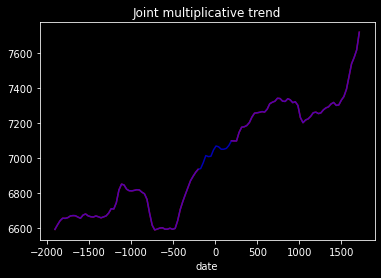

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose

column_="cirdeaths"

pd.concat(
    [
        seasonal_decompose(
            data.loc[slice(None, 0)][column_], period=12, model="multiplicative"
        ).trend,
        seasonal_decompose(
            data.loc[slice(0, None)][column_], period=12, model="multiplicative"
        ).trend,
    ]
).plot(color="red")

pd.concat(
    [
        seasonal_decompose(
            data[column_], period=12, model="multiplicative"
        ).trend,

    ]
).plot(color="blue", alpha=0.7)
plt.title("Joint multiplicative trend")

In [75]:
filter_joint = lambda df, column_, method, type="int", **kwargs: pd.concat(
    [
        method(df.loc[slice(None, 0)][column_], **kwargs)[1]
        if type == "int"
        else method(df.loc[slice(None, 0)][column_], **kwargs).trend,
        method(df.loc[slice(0, None)][column_], **kwargs)[1]
        if type == "int"
        else method(df.loc[slice(0, None)][column_], **kwargs).trend,
    ],
    axis=0,
)

filter = (
    lambda df, column_, method, type="int", **kwargs: method(df[column_], **kwargs)[1]
    if type == "int"
    else method(df[column_], **kwargs).trend
)

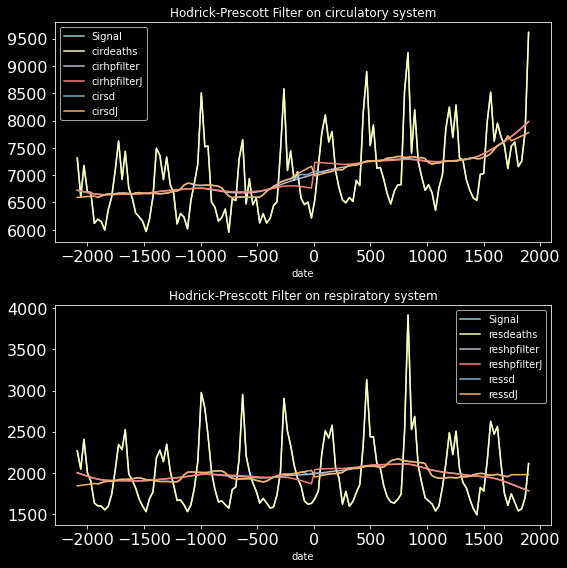

In [91]:
plt.figure(figsize=(8, 8))
gdp_decomp = data.copy()
for p, short_o in enumerate(short_outcome, 1):
    ax = plt.subplot(2, 1, p)
    column_ = "{}deaths".format(short_o[:3])

    # plot original signal
    gdp_decomp[column_].plot(
        ax=ax,
        fontsize=16,
        title="Hodrick-Prescott Filter on {}".format(short_o),
        label="Signal",
    )

    (
        gdp_decomp["{}hpfilter".format(short_o[:3])],
        gdp_decomp["{}hpfilterJ".format(short_o[:3])],
        gdp_decomp["{}sd".format(short_o[:3])],
        gdp_decomp["{}sdJ".format(short_o[:3])],
    ) = (
        filter(data, column_, sm.tsa.filters.hpfilter),
        filter_joint(data, column_, sm.tsa.filters.hpfilter),
        filter(
            data,
            column_,
            seasonal_decompose,
            type="notint",
            period=12,
            model="multiplicative",
        ),
        filter_joint(
            data,
            column_,
            seasonal_decompose,
            type="notint",
            period=12,
            model="multiplicative",
            extrapolate_trend="freq",
        ),
    )
    gdp_decomp.drop("time", axis=1)[[col for col in gdp_decomp.columns if column_[:3] in col]].plot(ax=ax)


    # gdp_decomp["{}sd".format(short_o[:3])].plot(ax=ax, label="sd")

    ax.legend()
    ax.set_ylim

plt.tight_layout()

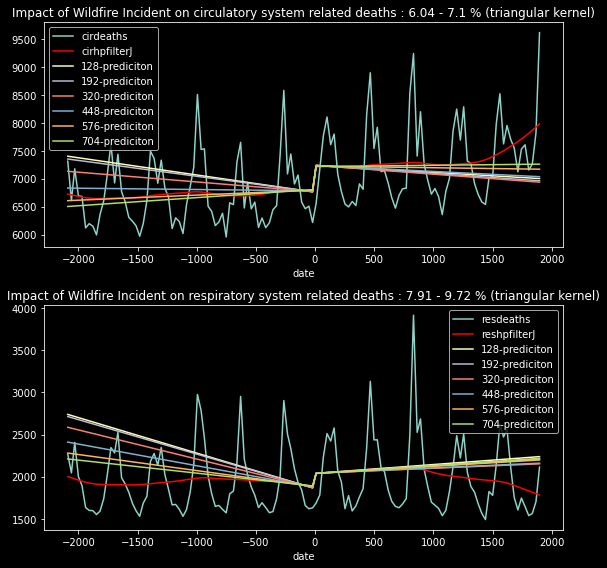

In [99]:
plt.figure(figsize=(8, 8))
rdd_df = gdp_decomp.assign(threshold=(gdp_decomp.index > 0).astype(int)).assign(
    date=rdd_df.index
)

method= "hpfilterJ"
for p, short_o in enumerate(short_outcome, 1):
    ax = plt.subplot(2, 1, p)
    rdd_df.plot(x="date", y="{}deaths".format(short_o[:3]), ax=ax)
    m = {
        (k + 1) * 64: smf.wls(
            f"{short_o[:3]}{method}~date*threshold",
            rdd_df,
            weights=kernel(rdd_df["date"], c=0, h=(k + 1) * 64),
        ).fit()
        for k in [1,2,4,6,8,10]
    }
    ate_pct = {
        window: 100
        * (
            (m_k.params["threshold"] + m_k.params["Intercept"])
            / m_k.params["Intercept"]
            - 1
        )
        for window, m_k in m.items()
    }

    rdd_df[["{}{}".format(short_o[:3], method)]].plot(ax=ax, color="red", label="filtered")

    rdd_df.assign(
        **{
            "{}-prediciton".format(window): m_k.fittedvalues
            for window, m_k in m.items()
        }
    ).plot(
        x="date", y=["{}-prediciton".format(window) for window in m.keys()], ax=ax
    )


    np.round(min(ate_pct.values()), 2), np.round(max(ate_pct.values()), 2)
    plt.title(
        f"Impact of Wildfire Incident on {short_o} related deaths : {np.round(min(ate_pct.values()), 2)} - {np.round(max(ate_pct.values()), 2)} % (triangular kernel)"
    )

plt.tight_layout()

/Users/arnaudpetit/mambaforge/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



fixed intercept estimated as 8137.325


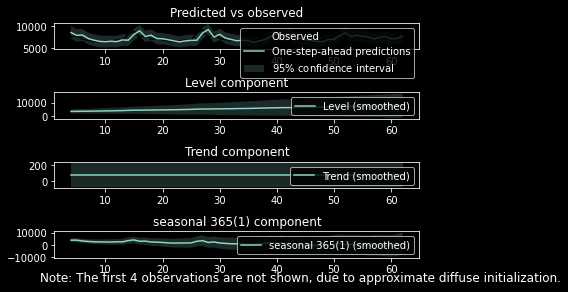

In [639]:
model = sm.tsa.UnobservedComponents(
    plot[slice(0,None)],
    level="local linear deterministic trend",
    freq_seasonal=[{"period": 365, "harmonics": 1}],
)
res_f = model.fit(disp=False)
#print(res_f.summary())
# The first state variable holds our estimate of the intercept
print(
    "fixed intercept estimated as {0:.3f}".format(
        res_f.smoother_results.smoothed_state[0, -1:][0]
    )
)
fig = res_f.plot_components()
fig.tight_layout(pad=1.0)

In [633]:
plot[slice(None,0)]

dtype('float64')

/Users/arnaudpetit/mambaforge/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



fixed intercept estimated as 4461.294


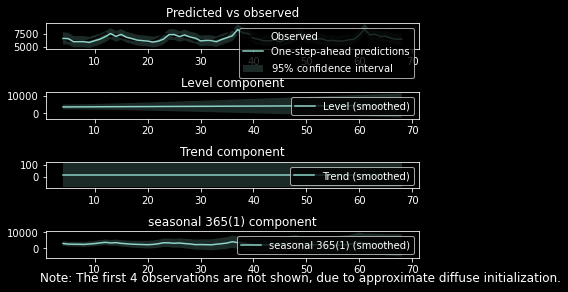

In [640]:
model = sm.tsa.UnobservedComponents(
    plot[slice(None,0)],
    level="local linear deterministic trend",
    freq_seasonal=[{"period": 365, "harmonics": 1}],
)
res_f = model.fit(disp=False)
#print(res_f.summary())
# The first state variable holds our estimate of the intercept
print(
    "fixed intercept estimated as {0:.3f}".format(
        res_f.smoother_results.smoothed_state[0, -1:][0]
    )
)
fig = res_f.plot_components()
fig.tight_layout(pad=1.0)